# Initial settings

In [12]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#Libraries
import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets as datasets_torch
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import UNet2DModel, DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

import torchvision
import matplotlib.pyplot as plt
import numpy as np

# MAIN

In [34]:
selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')

# load the config file
with open('config_playground.yaml') as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)
    
# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
logging_dir = pipeline_dir / config['logging']['dir_name']

# start the accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=config['training']['gradient_accumulation']['steps'],
    mixed_precision=config['training']['mixed_precision']['type'],
    log_with= config['logging']['logger_name'],
    logging_dir= logging_dir,
)

# show the accelerator state as first log message
print(accelerator.state)

data_dir = repo_path / config['processing']['dataset']
# load from local directory
dataset = load_dataset("imagefolder", data_dir=data_dir, name='breast10p', split='train')

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #getattr(InterpolationMode, config['processing']['interpolation'])),  # Smaller edge is resized to 256 preserving aspect ratio
        CenterCrop(config['processing']['resolution']),  # Center crop to the desired squared resolution
        #RandomHorizontalFlip(),  # Horizontal randomly flip (data augmentation)
        ToTensor(),  # Convert to tensor
        # divide by the maximum value of the image

        # normalize between -1 and 1
        Normalize([0.5], [0.5]),  # Map to (-1, 1) as a way to make data more similar to a Gaussian distribution
    ]
)

def transform(batch_dict):
    """Transform the images in the dataset to the desired format, this generates a dictionary with the key "images" containing the images in a list.
    It should include a formatting function as preproces. A formatting function is a callable that takes a batch as (dict) and returns a batch also as (dict).
    The formatting function is defined outside of the function (not self-contained)

    Args:
        batch_dict (dict): dictionary containing the images in a list under the key "image"

    Returns:
        dict: dictionary containing the images in a list under the key "images"
    """
    images = [preprocess(image.convert(mode='F')) for image in batch_dict["image"]]
    return {"images": images}
#set the transform function to the dataset

dataset = datasets_torch.ImageFolder(data_dir, transform=preprocess)
dataset.set_transform(transform)

# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=config['processing']['batch_size'], num_workers= 0, shuffle=True
)

The device is: cuda:0

Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no



In [33]:
xb[0,0]

tensor([[-0.5216, -0.9294, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [ 0.8510,  0.2549, -0.6000,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.0000,  0.9922,  0.7725,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000]])

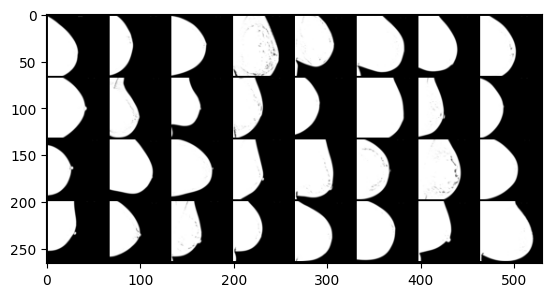

In [28]:
xb, _ = next(iter(train_dataloader))

x = xb
grid = torchvision.utils.make_grid(x,normalize=True)
grid_im = grid.detach().cpu().permute(1,2,0).numpy()
plt.imshow(grid_im, cmap='gray')

In [10]:
gray_example = xb[0,0]
# max value
print(f'Max value: {gray_example.max()}')

Max value: 6813.83154296875


(array([2.765e+03, 4.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([-1.00000000e+00,  9.63659913e-05,  1.00019276e+00, ...,
         7.26370020e+03,  7.26470020e+03,  7.26570020e+03]),
 <BarContainer object of 7266 artists>)

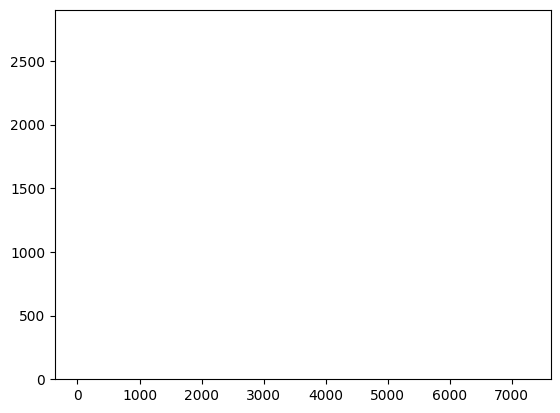

In [74]:

np.unique(gray_example)
# plot the histogram of the image
plt.hist(gray_example.flatten(), bins=int(gray_example.max()-gray_example.min()), range=(gray_example.min(), gray_example.max()))

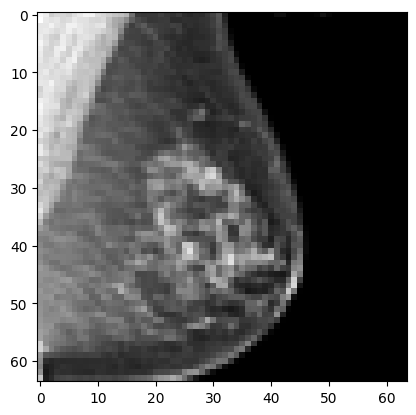

In [34]:
example = xb[0,0].cpu().numpy()
# plot the example
import matplotlib.pyplot as plt
plt.imshow(example, cmap='gray')

## Load model

In [35]:
from huggingface_hub import get_full_repo_name
from diffusers import DDPMPipeline

# Let's give our new model a name for the Hub
model_name = "Breast_unconditional_64"
hub_model_id = get_full_repo_name(model_name)

pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=1).images

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [49]:
# HP
image_size = 64

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
# model
model = pipeline.unet

# Random starting point (8 random images):
sample = torch.randn(8, 1, image_size, image_size).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample



100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s]


In [58]:
# plot one sample from the batch
example = sample[2,0].cpu().numpy()
# plot the example
np.unique(example)


array([-0.26468068, -0.24106541, -0.17163341, ...,  0.77424616,
        0.8445616 ,  1.        ], dtype=float32)